In [772]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest
from scipy import stats
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.max_rows = 10
pd.options.display.max_rows = 10

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions

In [815]:
def replace_labels(ax, char="%", axis='y'):
    # Customize y-labels
    if axis == 'x':
        _ = ticks_loc = ax.get_xticks().tolist()
        _ = ax.set_xticks(ticks_loc)
        _ = ax.set_xticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    if axis == 'y':
        _ = ticks_loc = ax.get_yticks().tolist()
        _ = ax.set_yticks(ticks_loc)
        _ = ax.set_yticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
        
def custom_barplot(x, y, **kwargs):
    ax = sns.barplot(x=x, y=y*100)
    replace_labels(ax, "%")
    
def get_samples_avgs(df, cat, cat_val, sample_size=20, n_samples=100, response="Loan_Status"):
    return np.array([df.loc[df[cat]==cat_val, response].sample(sample_size).mean() for i in range(sample_size)])

def get_test_result(name, score, p_value, significance=0.05):
    # Test the p-value
    print(f"{name}")
    print(f"Score: {score:0.2f} and p-value: {p_value:0.2f}")
    if (p_value < significance):
        print(f'H0 can be rejected!')
    else:
        print('Fail to reject H0')

### Import Data

In [774]:
df = pd.read_csv("data/train.csv")

### Explore Data

In [775]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [776]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [777]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [778]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [779]:
missing = df.isnull().sum()
missing[missing>0]

Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [780]:
df["Loan_Status"] = df["Loan_Status"].map({"Y":1, "N":0})

### Overall Loan Status

About 69% of the loans were approved, against 31% rejected.

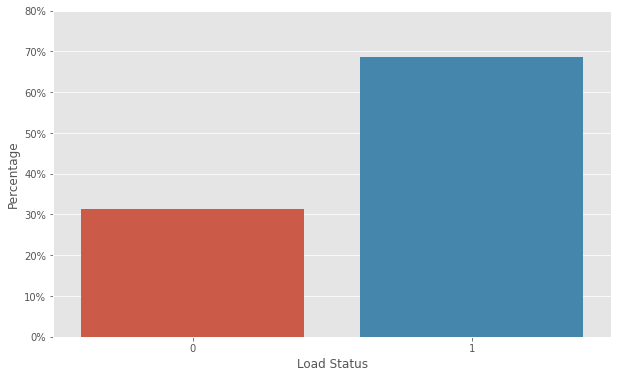

In [781]:

loan_stt = df['Loan_Status'].value_counts(normalize=True)*100
_ = ax = sns.barplot(loan_stt.index, loan_stt)
_ = ax.set_ylabel("Percentage")
_ = ax.set_xlabel("Load Status")
replace_labels(ax, "%")

### Categorical: Nominal

The `approval rate` among genders seems to be roughly the same, about 69% for men and 66% for women, we can say the same for the self employed status.

Look at the Marriage status, there is a significant difference in the `approval rate`, and the Credit History seems to be heavily important to the outcome of the loan eligibility.

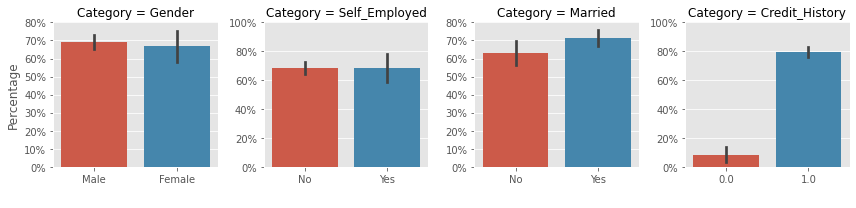

In [782]:

nominal_cat = df[["Gender", "Self_Employed","Married","Credit_History","Loan_Status"]]
melted_cat_vars = pd.melt(nominal_cat, id_vars=["Loan_Status"],var_name='Category')

g = sns.FacetGrid(
        melted_cat_vars, col="Category", sharex=False, sharey=False,
    )
g.map(custom_barplot, "value", "Loan_Status")
g.set_axis_labels(y_var="Percentage",x_var=" ")
plt.tight_layout()

These hyphotesis may be not true, so let's use statistical tests to confirm or refute.

The null hypothesis is that Gender, Self Employed status, Marriage Status, or Credit history,  doesn't affect the `approval rate`, in other words, "nothing special is going on", and the observed difference is due to chance.

$H_0:$ There is **no association** between Loan_Status and other factor<br>
$H_A:$ There is **an association** between Loan_Status and other factor

The _approval rate_ is independent from **Gender**.

In [819]:
contigency_table = pd.crosstab(df['Gender'],df['Loan_Status'])
chi2, p, _ , _ = stats.chi2_contingency(contigency_table)
get_test_result(name="chi-square", score=chi2, p_value=p)

chi-square test
Score: 0.14 and p-value: 0.71
Fail to reject H0


The _approval rate_ is independent from **Self_Employeed** Status.

In [823]:
contigency_table = pd.crosstab(df['Self_Employed'],df['Loan_Status'])
chi2, p, _ , _ = stats.chi2_contingency(contigency_table)
get_test_result(name="chi-square", score=chi2, p_value=p)

chi-square test
Score: 0.00 and p-value: 1.00
Fail to reject H0


The _approval rate_ is dependent from **Marriage** Status.

In [825]:
contigency_table = pd.crosstab(df['Married'],df['Loan_Status'])
chi2, p, _ , _ = stats.chi2_contingency(contigency_table)
get_test_result(name="chi-square", score=chi2, p_value=p)

chi-square test
Score: 4.48 and p-value: 0.03
H0 can be rejected!


The _approval rate_ is dependent from **Credit_History**

In [826]:
contigency_table = pd.crosstab(df['Credit_History'],df['Loan_Status'])
chi2, p, _ , _ = stats.chi2_contingency(contigency_table)
get_test_result(name="chi-square test", score=chi2, p_value=p)

chi-square test
Score: 174.64 and p-value: 0.00
H0 can be rejected!


### Categorical: Ordinal

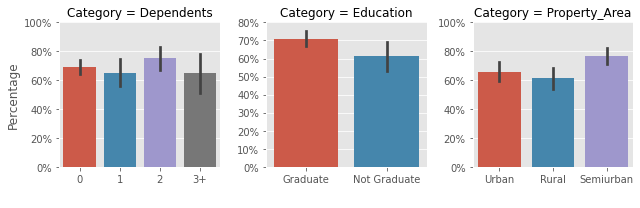

In [788]:
ordinal_cat = df[['Dependents','Education', 'Property_Area','Loan_Status']]
melted_cat_vars = pd.melt(ordinal_cat, id_vars=["Loan_Status"],var_name='Category')

g = sns.FacetGrid(
        melted_cat_vars, col="Category", sharex=False, sharey=False,
    )
g.map(custom_barplot, "value", "Loan_Status")
g.set_axis_labels(y_var="Percentage",x_var=" ")
plt.tight_layout()

### Numerical

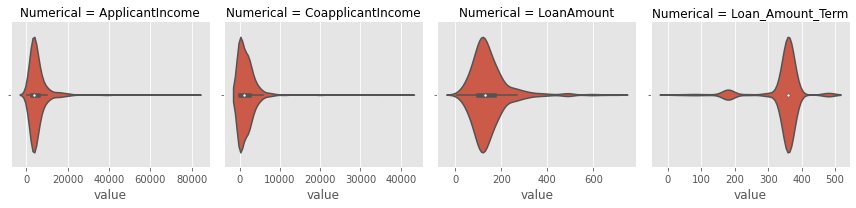

In [789]:
numerical = df[['ApplicantIncome','CoapplicantIncome', 'LoanAmount','Loan_Amount_Term','Loan_Status']]

melted_num_vars = pd.melt(numerical, id_vars=["Loan_Status"],var_name='Numerical')
g = sns.FacetGrid(
        melted_num_vars, col="Numerical", sharex=False, sharey=False,
    )
g.map(sns.violinplot, "value")
plt.tight_layout()